In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
#%matplotlib inline
#%matplotlib notebook

import RIFT.lalsimutils as lalsimutils
import EOSManager
import lalsimulation as lalsim
#import lalsim_EOS_tools as let
from scipy.integrate import nquad
#import EOS_param as ep
import os
from EOSPlotUtilities import render_eos
import lal

matplotlib.rcParams.update({'font.size': 12.0,  'mathtext.fontset': 'stix'})
matplotlib.rcParams['figure.figsize'] = (9.0, 7.0)
matplotlib.rcParams['xtick.labelsize'] = 15.0
matplotlib.rcParams['ytick.labelsize'] = 15.0
matplotlib.rcParams['axes.labelsize'] = 25.0
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('seaborn-v0_8-whitegrid')

eos_names =  ['LALSimNeutronStarEOS_AP4.dat',
              'LALSimNeutronStarEOS_PAL6.dat',
              'LALSimNeutronStarEOS_AP3.dat',
              'LALSimNeutronStarEOS_MPA1.dat',
              'LALSimNeutronStarEOS_WFF1.dat',
              'LALSimNeutronStarEOS_GNH3.dat']
colors = ['b','g','r','c','m','y']

[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.9.3
  numpy :  1.23.5


LALSimNeutronStarEOS_AP4.dat
LALSimNeutronStarEOS_PAL6.dat
LALSimNeutronStarEOS_AP3.dat
LALSimNeutronStarEOS_MPA1.dat
LALSimNeutronStarEOS_WFF1.dat
LALSimNeutronStarEOS_GNH3.dat


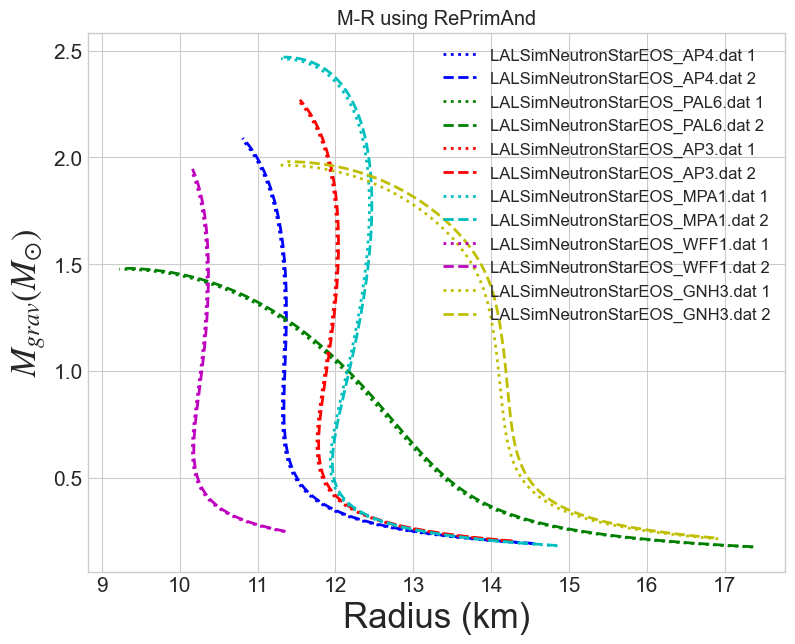

In [5]:
i=0
import pyreprimand as pyr

for name in eos_names:
    print(name)
    data = np.loadtxt("/home/atul.kedia/lalsuite_dir/lalsuite/lalsimulation/lib/"+name, delimiter = "\t")
    neweos = EOSManager.EOSFromTabularData(eos_data=data)
    
    min_pseudo_enthalpy = 0.005
    max_pseudo_enthalpy = lalsim.SimNeutronStarEOSMaxPseudoEnthalpy(neweos.eos)
    hvals = max_pseudo_enthalpy* 10**np.linspace( np.log10(min_pseudo_enthalpy/max_pseudo_enthalpy),  0,num=500)
    xvar, yvar='energy_density', 'pressure'
    qry = EOSManager.QueryLS_EOS(neweos.eos)
    edens = qry.extract_param('energy_density',hvals)
    press = qry.extract_param('pressure',hvals)
    p_enthalpy = qry.extract_param('pseudo_enthalpy',hvals)
    rho = qry.extract_param('rest_mass_density',hvals)
    cs = qry.extract_param('sound_speed_over_c',hvals)
    
    param_dict = {'pseudo_enthalpy': p_enthalpy,'rest_mass_density': rho,'energy_density': edens,'pressure': press,'sound_speed_over_c': cs}
    param_dict = EOSManager.eos_monotonic_parts_and_causal_sound_speed(param_dict)
    p_enthalpy = param_dict['pseudo_enthalpy']; rho = param_dict['rest_mass_density']; edens = param_dict['energy_density']; press = param_dict['pressure']; cs = param_dict['sound_speed_over_c']
    
    spec_int_energy = edens/rho -1
    
    unew = pyr.units.geom_solar()
    spec_int_energy_unew = spec_int_energy
    rho_unew = rho*1000/unew.density
    press_unew = press*0.1/unew.pressure
    
    temp, efrac= [], []
    n_poly=1.7115960633290546
    eps_0 = 0.0
    pts_per_mag =1000
    isentropic = True
    rgrho = pyr.range(min(rho_unew)*1.0000001, max(rho_unew) / 1.0000001)
    #select density range carefully. Not clear currently.
    
    eos1 = pyr.make_eos_barotr_spline(rho_unew, spec_int_energy_unew, press_unew, cs, temp, efrac, isentropic, rgrho, n_poly, unew, pts_per_mag)
    eos2 = pyr.make_eos_barotr_spline(rho_unew, press_unew, cs, temp, efrac, rgrho, n_poly, eps_0, unew, pts_per_mag)
    
    mrl1 = EOSManager.make_mr_lambda_reprimand(eos1)
    mrl2 = EOSManager.make_mr_lambda_reprimand(eos2)
    
    plt.plot(mrl1[:,1], mrl1[:,0], color = colors[i], ls = 'dotted' , label = name + ' 1')
    plt.plot(mrl2[:,1], mrl2[:,0], color = colors[i], ls = 'dashed', label = name + ' 2')
    i +=1
plt.title('M-R using RePrimAnd')
plt.xlabel('Radius (km)')
plt.ylabel(r"$M_{grav} (M_{\odot})$")
plt.legend()
plt.show()